<a href="https://colab.research.google.com/github/Bhargavi1504/Regression-algorithms/blob/main/Random_Forest_reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import LabelEncoder
import random

np.random.seed(42)
n_samples=1000

#meanures or fraction
missing_fraction = 0.1
duplicate_fraction = 0.05
outlier_fraction = 0.03

#generating functions
def random_generator_of_cat(choice,n_samples):
  return np.random.choice(choice,n_samples)

def generate_dates(n_samples):
  base = datetime.today()
  return [base- timedelta(days=random.randint(0,2000)) for _ in range(n_samples)]


#synthetic data
age=np.random.randint(6,80,n_samples)
experience=np.clip(age-np.random.randint(8,25,n_samples),0,None)
education= random_generator_of_cat(['Bachelors','Masters','PHD'],n_samples)
city = random_generator_of_cat(['New York', 'San Francisco', 'Chicago', 'Austin'],n_samples)
job_role = random_generator_of_cat(['Data Scientist','Data Analyst','Data Engineer'],n_samples)
gender = random_generator_of_cat(['Male', 'Female', 'Other'], n_samples)
join_date = generate_dates(n_samples)
performance = np.random.normal(70,10,n_samples).round(2)
working_hours= np.random.normal(40,5,n_samples).round(1)
married = np.random.choice([0, 1], n_samples)
social_activity = np.random.normal(2, 1, n_samples).round(1)

# Multicollinear & noisy features
salary = experience * 3000 + age* 200 + np.random.normal(0,1000,n_samples)
loan_amount = salary * 0.3 + np.random.normal(0,5000,n_samples)
spending_score= np.random.normal(50,20,n_samples).round(1)
rating = np.random.randint(1, 6, n_samples)
target_salary = salary * 1.1 + np.random.normal(0, 3000, n_samples)
will_churn = np.random.choice([0, 1], n_samples, p=[0.7, 0.3])

#dataframe
d=pd.DataFrame({
    'Age': age,
    'salary': salary.round(2),
    'experience': experience,
    'education_level': education,
    'city': city,
    'job_role': job_role,
    'gender': gender,
    'join_date': join_date,
    'performance': performance,
    'working_hours': working_hours,
    'married': married,
    'loan_amount': loan_amount.round(2),
    'spending_score': spending_score,
    'rating': rating,
    'social_activity': social_activity,
    'target_salary': target_salary.round(2),
    'will_churn': will_churn

})

#inject missing values
for i in d.columns:
  d.loc[d.sample(frac=missing_fraction).index,i]=np.nan

#inject duplicates
num_duplicates=int(n_samples * duplicate_fraction)
duplicate_rows=d.sample(num_duplicates)
d=pd.concat([d,duplicate_rows],ignore_index=True)

#inject outliers
def inject_outliers(d,column,fraction = outlier_fraction,factor=10):
    num_outliers = int(len(d)* fraction)
    indices = np.random.choice(d.index,num_outliers,replace=True)
    d.loc[indices,column] *= factor

inject_outliers(d, 'salary')
inject_outliers(d, 'loan_amount')

#encoded
d_encoded=d.copy()
label_cols= ['education_level', 'city', 'job_role', 'gender']
encoders={}
for c in label_cols:
  le=LabelEncoder()
  d_encoded[c] = d_encoded[c].astype(str) #avoid NaNs
  d_encoded[c]=le.fit_transform(d_encoded[c])
  encoders[c]= le

#saving
d.to_csv("dirty_dataset.csv", index=False)
d_encoded.to_csv("dirty_dataset_encoded.csv", index=False)

print("✅ Dirty dataset and encoded version saved!")

✅ Dirty dataset and encoded version saved!


In [2]:
#2.1 Load & Drop Missing Target

drf = pd.read_csv("dirty_dataset_encoded.csv")
drf = drf.dropna(subset=['target_salary'])
print("Initial Shape after dropping null targets:", drf.shape)

Initial Shape after dropping null targets: (941, 17)


In [3]:
#.2 Impute Missing Values (numerical) – Optional but safe
from sklearn.impute import SimpleImputer

num_cols = drf.select_dtypes(include=['float64', 'int64']).columns
imputer = SimpleImputer(strategy='median')
drf[num_cols] = imputer.fit_transform(drf[num_cols])

In [5]:
#2.3 Drop Duplicates

drf = drf.drop_duplicates()
print("Shape after dropping duplicates:", drf.shape)

Shape after dropping duplicates: (902, 17)


In [6]:
#2.4 Remove Outliers in Target (optional)

def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    mask = (data[column] >= Q1 - 1.5 * IQR) & (data[column] <= Q3 + 1.5 * IQR)
    return data[mask]

df = remove_outliers_iqr(drf, 'target_salary')
print("Shape after outlier removal:", drf.shape)

Shape after outlier removal: (902, 17)


In [7]:
#Step 3: Prepare Features and Target

X = drf.drop(columns=['target_salary', 'will_churn', 'join_date'])
y = drf['target_salary']

In [8]:
#Step 4: Train-Test Split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
#model_training
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"Train RMSE: {rmse_train:.2f} | R²: {r2_train:.4f}")
print(f"Test RMSE : {rmse_test:.2f}  | R²: {r2_test:.4f}")


Train RMSE: 3067.61 | R²: 0.9983
Test RMSE : 5422.40  | R²: 0.9946


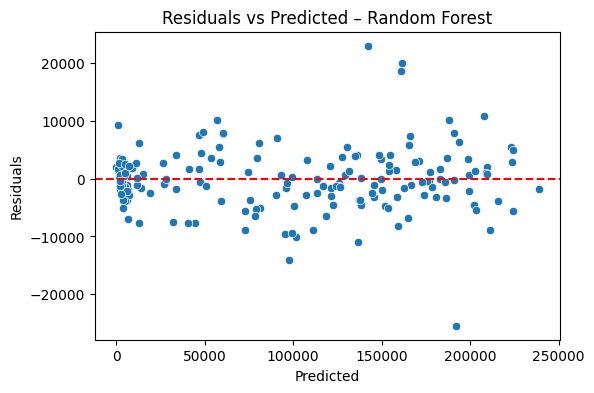

In [10]:
#residual analysis
import matplotlib.pyplot as plt
import seaborn as sns

residuals = y_test - y_pred_test

plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred_test, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted – Random Forest")
plt.show()


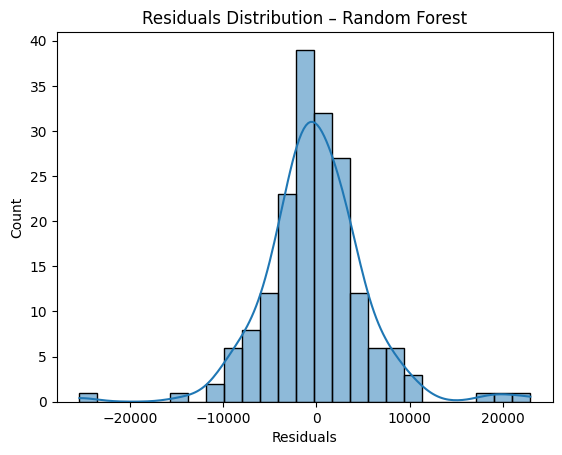

In [11]:
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution – Random Forest")
plt.xlabel("Residuals")
plt.show()


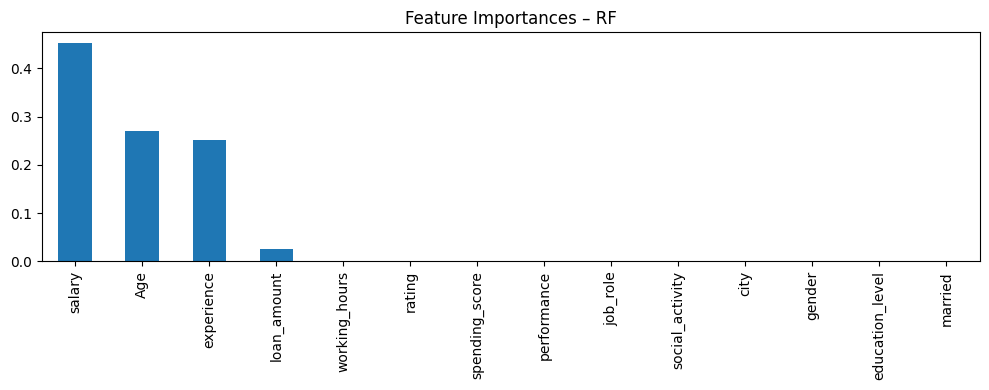

In [15]:
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(10, 4), title="Feature Importances – RF")
plt.tight_layout()
plt.show()


MAE (Test): 3806.96
MAPE (Test): 333.81%


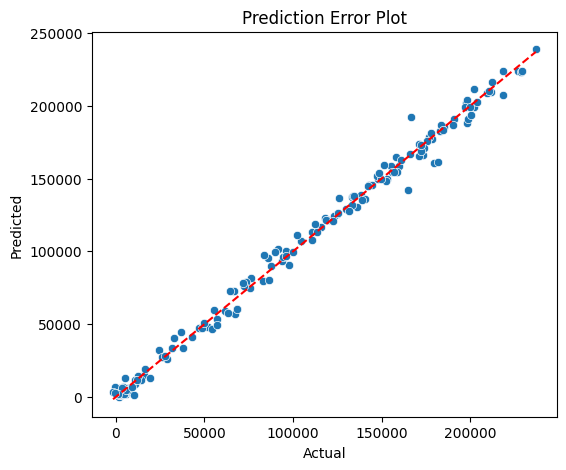

In [16]:
#reg metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print(f"MAE (Test): {mae_test:.2f}")
print(f"MAPE (Test): {mape_test * 100:.2f}%")

#Prediction Error Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 5))
sns.scatterplot(x=y_test, y=y_pred_test)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Prediction Error Plot")
plt.show()


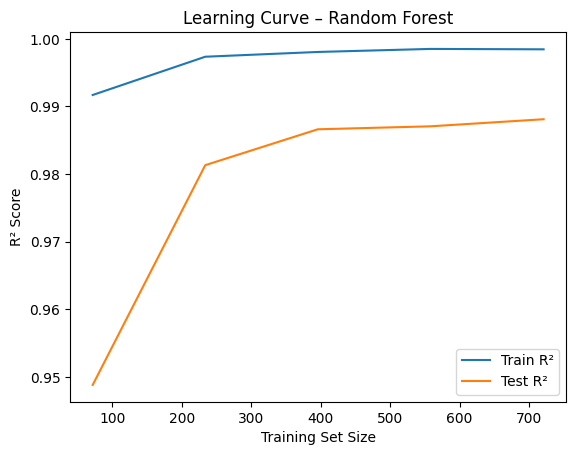

In [17]:
#. Learning Curve (Optional)
#Helps detect overfitting/underfitting trend.


from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    rf, X, y, cv=5, scoring='r2', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5), shuffle=True, random_state=42
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label="Train R²")
plt.plot(train_sizes, test_mean, label="Test R²")
plt.title("Learning Curve – Random Forest")
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.legend()
plt.show()


In [18]:
#5. K-Fold Cross-Validation
#To check model generalization beyond one split.

from sklearn.model_selection import cross_val_score

cv_r2 = cross_val_score(rf, X, y, cv=5, scoring='r2')
cv_rmse = -cross_val_score(rf, X, y, cv=5, scoring='neg_root_mean_squared_error')

print(f"Cross-validated R²: {cv_r2.mean():.4f} ± {cv_r2.std():.4f}")
print(f"Cross-validated RMSE: {cv_rmse.mean():.2f} ± {cv_rmse.std():.2f}")

Cross-validated R²: 0.9884 ± 0.0077
Cross-validated RMSE: 7484.53 ± 2340.33
